# ERO2 : Un petit TP

Ce document est à compléter, il sert d'évaluation sommative pour la première itération du cours d'ERO2. Merci de formuler vos questions sur le forum moodle prévu à cet effet.

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

## *Given Files*

Cette section regroupe les éléments déjà préalablement à votre disposition, vous êtes libres de vous en servir pour répondre aux différentes questions du TP.

In [4]:
class Wline():

    def __init__(self, size=None, policy=(lambda x: 0)): #here this is fifo, lambda x:-1 would be lifo
        self.size = size
        self.next = policy
        self.queue = []
        
    def populate(self, queue):
        if self.size is not None and len(queue) > self.size:
            print(f"Error: The size of the input queue is larger than the maximum size {self.size}.")
            return
        self.queue = queue
        
    def add(self, item):
        if self.size is None or len(self.queue) < self.size:
            self.queue.append(item)
            return True
        else:
            print("Error: The queue is full. Cannot add more items.")
            return False
    
    def pop(self):
        pop_ix = self.next(self.queue)
        pop_val = None

        if -len(self.queue) <= pop_ix < len(self.queue) : # Here there was a mistake, it's "<=" not "<"
            pop_val = self.queue[pop_ix]
            self.queue.pop(pop_ix)
            
        return pop_val
    def is_empty(self):
        return len(self.queue) == 0

In [5]:
#Since apparently there are issues in the code I will need to thoroughly test everything


def test_Wline():

    # Test FIFO behavior
    queue = Wline(size=3, policy=(lambda x: 0))
    queue.populate([1, 2, 3])
    assert queue.pop() == 1, "Error in test_Wline: FIFO behavior not working correctly."
    assert queue.pop() == 2, "Error in test_Wline: FIFO behavior not working correctly."
    assert queue.pop() == 3, "Error in test_Wline: FIFO behavior not working correctly."
    
    # Test LIFO behavior
    queue = Wline(size=3, policy=(lambda x: -1))
    queue.populate([1, 2, 3])
    assert queue.pop() == 3, "Error in test_Wline: LIFO behavior not working correctly."
    assert queue.pop() == 2, "Error in test_Wline: LIFO behavior not working correctly."
    assert queue.pop() == 1, "Error in test_Wline: LIFO behavior not working correctly."
    assert queue.pop() == None

    # Test size limit
    queue = Wline(size=3)
    queue.populate([1, 2, 3, 4])  # This should print an error message
    queue.populate([1, 2, 3])
    queue.add(4)  # This should also print an error message
    assert len(queue.queue) == 3, "Error in test_Wline: Size limit not working correctly."
    
    print("All tests passed successfully.")
    
# Run the tests
test_Wline()


Error: The size of the input queue is larger than the maximum size 3.
Error: The queue is full. Cannot add more items.
All tests passed successfully.


In [6]:
class InService():
    
    def __init__(self, nb=1, dist=None):
        self.nb = nb
        self.server = [None]*nb
        self.dist = dist
        
    def full(self):
        return not (None in self.server)
        
    def leaving(self, tops):
        
        agent_id = None
        
        if not self.full():
            #Extract index of an available server
            srv_ix = self.server.index(None) 
            
        
        else:
            #Find agent of smallest departure time, needs to be float to use idxmin
            agent_id = tops.loc[self.server, 't_depart_sys'].astype(float).idxmin()
            #Extract server number of departing agent
            srv_ix = self.server.index(agent_id) 
        
        return srv_ix, agent_id

In [51]:
class QS():
    
    def __init__(self, arval_dist, srv_dist, servers_nb, 
                 queue_size=None, policy=lambda x:0, test_size=100) :
         
        #Initializing metadata
        self.arval_dist = arval_dist
        self.srv_dist = srv_dist
        self.srv_z = servers_nb
        self.queue_z = queue_size if queue_size else test_size
        self.test_z = test_size

        #Initializing Waiting Line
        self.wline = Wline(size=queue_size, policy=policy)
        
        #Initializing In Service List
        self.inservice = InService(nb=servers_nb, dist=srv_dist)
        
        #Initializin tops dataframe
        column_names = ['t_arval_queue', 't_arval_srv', 't_depart_sys']
        self.tops = pd.DataFrame(np.empty((test_size, 3),dtype=object), columns=column_names)
        
    def pretreat(self):
        
        #Easing naming
        tops = self.tops

        t_interarvals = self.arval_dist(size=(self.test_z))
        tops.loc[0, 't_arval_queue'] = t_interarvals[0]
                
        for agent in range(1, self.test_z) :
            tops.loc[agent, 't_arval_queue'] = tops.loc[agent - 1, 't_arval_queue'] + t_interarvals[agent]
        #print("arrival times :", tops['t_arval_queue'])
        
       # t_interarvals = self.srv_dist(size=(self.test_z))
        # Call the lambda function and store its output in x
       # print(t_interarvals)  # Print the value of x

        
    def run(self):

        # Easing naming
        wline = self.wline
        inservice = self.inservice
        tops = self.tops
        processing_times = inservice.dist(size=(self.test_z))

        # Initializing arrival queue
        # Get the arrival times from the tops DataFrame
        arrival_times = tops['t_arval_queue'].values

        # wline.queue = list(tops.loc[:self.queue_z].index)
        wline.queue = list(tops.loc[0:0].index)  # Add the first agent to the waiting line
        # Initializing upcomgin theoretical arrival
        buffer_ix = 1
        current_time = arrival_times[0]

        #print(current_time)

        while buffer_ix < self.test_z:
            _next = wline.pop()
            if _next is not None:  # Waiting line is not empty
                #print(f"_next : {_next}")
                # print(f"arrival of next : {tops.loc[_next, 't_arval_queue']}")

                # Update server arrival time as if no waiting was needed
                tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']

                # Find next available server
                srv_ix, dept_ag = inservice.leaving(tops)

                # Fill available server with corresponding next agent in waiting line
                inservice.server[srv_ix] = _next

                if dept_ag is not None:
                    if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys']:
                        # Update server arrival time in case arrival is before system departure
                        tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']

                # Update system departure time
                tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + processing_times[_next]
                current_time = tops.loc[inservice.server, 't_depart_sys'].min()

            else:
                current_time = arrival_times[buffer_ix]  # Get next arrival time, in case we don't get any clients by the time we are done processing current client


            while buffer_ix < self.test_z and arrival_times[buffer_ix] <= current_time:
                in_system = ((tops['t_depart_sys'] > current_time) | (tops.index.isin(wline.queue)) | (tops.index == _next)).sum()
                if self.queue_z is not None and in_system >= self.queue_z + self.inservice.nb:
                    tops.loc[buffer_ix, 't_depart_sys'] = -1
                else:
                    wline.add(buffer_ix)
                buffer_ix += 1

            #buffer_ix += 1
            if (_next != None):
                current_time = tops.loc[_next, 't_depart_sys']
            #print("Current Time: ", current_time)
            #print("Current Queue:", wline.queue)

            # ok so in lifo I noticed that the first length - 1 elements don't ever get processed
            # because our server is too slow so once the buffer_ix gets exceeded, it cuts everything off.
            # I still want to process the queue
        while not wline.is_empty():
            """
            this loop is to finish processing the queue, otherwise the stats are completely off since those agents that have
            been waiting this entire time don't ever get accounted in our dataframe
            """
            _next = wline.pop()
            #print(f"_next : {_next}")
            # print(f"arrival of next : {tops.loc[_next, 't_arval_queue']}")

            # Update server arrival time as if no waiting was needed
            tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']

            # Find next available server
            srv_ix, dept_ag = inservice.leaving(tops)

            # Fill available server with corresponding next agent in waiting line
            inservice.server[srv_ix] = _next

            if dept_ag is not None:
                if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys']:
                    # Update server arrival time in case arrival is before system departure
                    tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']

            # Update system departure time
            tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + processing_times[_next]
            current_time = tops.loc[inservice.server, 't_depart_sys'].min()
            #print("Current Time: ", current_time)
            #print("Current Queue:", wline.queue)

                
    def posttreat(self):
        
        #Easing naming
        tops = self.tops
        
        tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
        tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
        tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
        tops['blocked'] = tops.loc[:,'t_depart_sys'] == -1
        tops['waited'] = tops['t_waiting'] > 0 
        
    
    def timeline(self, t_delation=2):
        
        #Easing naming
        tops = self.tops
        test_z = self.test_z

        # Process determination
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., tops['t_depart_sys'].max(), t_delation*test_z)
        process = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)
        
        for t in process.index:
            process.loc[t, 'ag_in_sys'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_depart_sys'])).sum()
            process.loc[t, 'ag_in_queue'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_arval_srv'])).sum()
            process.loc[t, 'ag_in_service'] = ((t > tops['t_arval_srv']) & (t <= tops['t_depart_sys'])).sum()
        
        # Statistics extractions
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 
                     'waiting_proportion', 'blocked_proportion', 'servers_max_usage']
        stats = pd.DataFrame(np.empty((len(statnames), 1),dtype=object), index=statnames, columns=['run value'])
 
        stats.loc['mean_sojourn_time'] = tops['t_sojourn'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_waiting_time'] = tops['t_waiting'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_service_time'] = tops['t_service'].sum() / (~tops['blocked']).sum()

        stats.loc['waiting_proportion'] = tops['waited'].sum() / (~tops['blocked']).sum()
        stats.loc['blocked_proportion'] = tops['blocked'].sum() / test_z

        # An approximation of server usage, for better approximation raise t_delation.
        stats.loc['servers_max_usage'] = (process['ag_in_service'] == self.inservice.nb).sum() / (t_delation*test_z - 1)
        
        # Calculate longest wait time
        longest_wait_time = tops['t_waiting'].max()
        
        #Caculate the standard deviation
        wait_time_std = tops['t_waiting'].std()
        
        
        stats.loc['longest_wait_time'] = longest_wait_time
        stats.loc['wait_time_std'] = wait_time_std
        return process, stats

# Question 1

1. Comparer les comportements de files M/M/1/k et M/M/1/k/LIFO au regard des métriques qui vous semblent pertinentes. Appuyez vos conclusions de simulations et contextualisez vos choix.
2. Vos conclusions changent-elles dans le cas des M/M/1 et M/M/1/LIFO ?

## Work done

Run function had to be completely redone to do LIFO. Now I have a queue that isn´t fixed to a size 1 but actually the size of the queue and fills up accordingly. This allows us to use LIFO properly. I also added a system that fills the queue based on the current time. The current time is updated at each important event (departure time or arrival time if queue is empty).
I also noticed that the whole bufferx loop was fine for FIFO but for LIFO left some discrepencies in the stats because the loop would end while the queue was full which mean the waiting time for the first elements of the queue (which are very high) were never considered. So once by bufferx exceeds our test size then I process the whole queue.

Then there were a lot of issues with rng, because we had different samples between our fifo and lifo, it made for a poor comparison, we don´t know if the randomness was causing the differences or the different structures were causing the differences.
So I had to set the sample sizes like the arrival times to be identical between the fifo and lifo instance, also because different queue systems end up accepting different agents, I just set all of our srv dist to the same value so that doesn´t cause different of samplings of our srv_dist. 

In [52]:
def simulate(srv_nb, queue_size, test_size, seed, arrival_speed: float, srv_speed: float):
    rng = np.random.default_rng(seed=seed)
    srv_nb = srv_nb
    arval_dist = lambda size : rng.exponential(arrival_speed, size=size)
    #srv_dist = rng.exponential(srv_speed, size=size)
    
    srv_dist = lambda size : [srv_speed] * size 
    fifo_policy = lambda x : 0
    lifo_policy = lambda x : (-1)
    #define the population size
    test_size = test_size
    queue_size = queue_size

    # Generate the same random samples for both policies
    arival_dist_samples = arval_dist(size=test_size)
    srv_dist_samples = srv_dist(size=test_size)
    # Create instances of QS with the same arrival and service times
    mm1_fifo = QS(lambda size: arival_dist_samples, lambda size:srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=fifo_policy)
    mm1_lifo = QS(lambda size: arival_dist_samples,lambda size: srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=lifo_policy)
    #define the population size
    test_size = test_size
    queue_size = queue_size

    # Generate the same random samples for both policies
    arival_dist_samples = arval_dist(size=test_size)
    srv_dist_samples = srv_dist(size=test_size)
    
    # Create instances of QS with the same arrival and service times
    mm1_fifo = QS(lambda size: arival_dist_samples, lambda size:srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=fifo_policy)
    mm1_lifo = QS(lambda size: arival_dist_samples,lambda size: srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=lifo_policy)

    mm1_fifo.pretreat()
    mm1_lifo.pretreat()
    
    mm1_fifo.run()
    mm1_lifo.run()
    
    mm1_fifo.posttreat()
    mm1_lifo.posttreat()
    
    mm1_fifo_bench, mm1_fifo_stats = mm1_fifo.timeline()
    mm1_lifo_bench, mm1_lifo_stats = mm1_lifo.timeline()
    
    display(mm1_fifo_stats.join(mm1_lifo_stats, lsuffix="_fifo", rsuffix="_lifo"))
    
    fig, axes = plt.subplots(3, 2, figsize=(32, 12))
    counts = ['ag_in_sys','ag_in_queue','ag_in_service']
    labels = ['system', 'queue', 'service']
    colors = ['red', 'blue', 'black']

    for i in range(3):
        mm1_fifo_bench.plot(y= counts[i], 
                       use_index=True, ax=axes[i,0], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                       ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_fifo_bench['ag_in_sys']+1)])

        mm1_lifo_bench.plot(y= counts[i], 
                       use_index=True, ax=axes[i,1], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                       ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_lifo_bench['ag_in_sys']+1)])

In [53]:
rng = np.random.default_rng(seed=42)

In [54]:
srv_nb = 1
arval_dist = lambda size : rng.exponential(1./60, size=size)
srv_dist = lambda size : [1./40] * size # rng.exponential(1./4., size=size)
#srv_dist = lambda size: rng.exponential(1./40, size=size)

fifo_policy = lambda x : 0
lifo_policy = lambda x : (-1)

I noticed that the random distribution for fifo and lifo generated different samples, it's good that they are random so that we can compare many fifos and many lifos but when comparing the 2 they should be running on the same set of samples.

In [55]:
#define the population size
test_size = 100
queue_size = 10

# Generate the same random samples for both policies
arival_dist_samples = arval_dist(size=test_size)
srv_dist_samples = srv_dist(size=test_size)


In [56]:
# Create instances of QS with the same arrival and service times
mm1_fifo = QS(lambda size: arival_dist_samples, lambda size:srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=fifo_policy)
mm1_lifo = QS(lambda size: arival_dist_samples,lambda size: srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=lifo_policy)

In [57]:
mm1_fifo.pretreat()
mm1_lifo.pretreat()

In [58]:
mm1_fifo.run()
mm1_lifo.run()

0.040070143399433246
0.040070143399433246


In [59]:
mm1_fifo.posttreat()
mm1_lifo.posttreat()

In [60]:
mm1_fifo_bench, mm1_fifo_stats = mm1_fifo.timeline()
mm1_lifo_bench, mm1_lifo_stats = mm1_lifo.timeline()

In [61]:
mm1_fifo_stats.join(mm1_lifo_stats, lsuffix="_fifo", rsuffix="_lifo")

,run value_fifo,run value_lifo
mean_sojourn_time,0.204626,0.204626
mean_waiting_time,0.179626,0.179626
mean_service_time,0.025,0.025
waiting_proportion,0.955224,0.955224
blocked_proportion,0.33,0.33
servers_max_usage,0.959799,0.959799
longest_wait_time,0.249935,1.494114
wait_time_std,0.106524,0.340006


As can be denoted from the results, the mean_service_time and mean_sojourn_time are exact same if you don´t introduce any randomness.

We find that the average wait time and sojourn time is **identical**.
The service time isn´t really pertinent as it as to do with the srv_dist.
    We can also see that the standard deviation and longest wait time are much higher for lifo than for fifo. This makes a lot of sense since lifo will make the first agent wait the entire queue as the queue is building, so the whole time the queue is open + the time it takes to process all other agents in the queue.
    
I'm sure you could achieve similar results without removing randomness by having a very large sample size, like a large test size because of the law of large numbers. But why do this when we can simply test on the same sample sets.

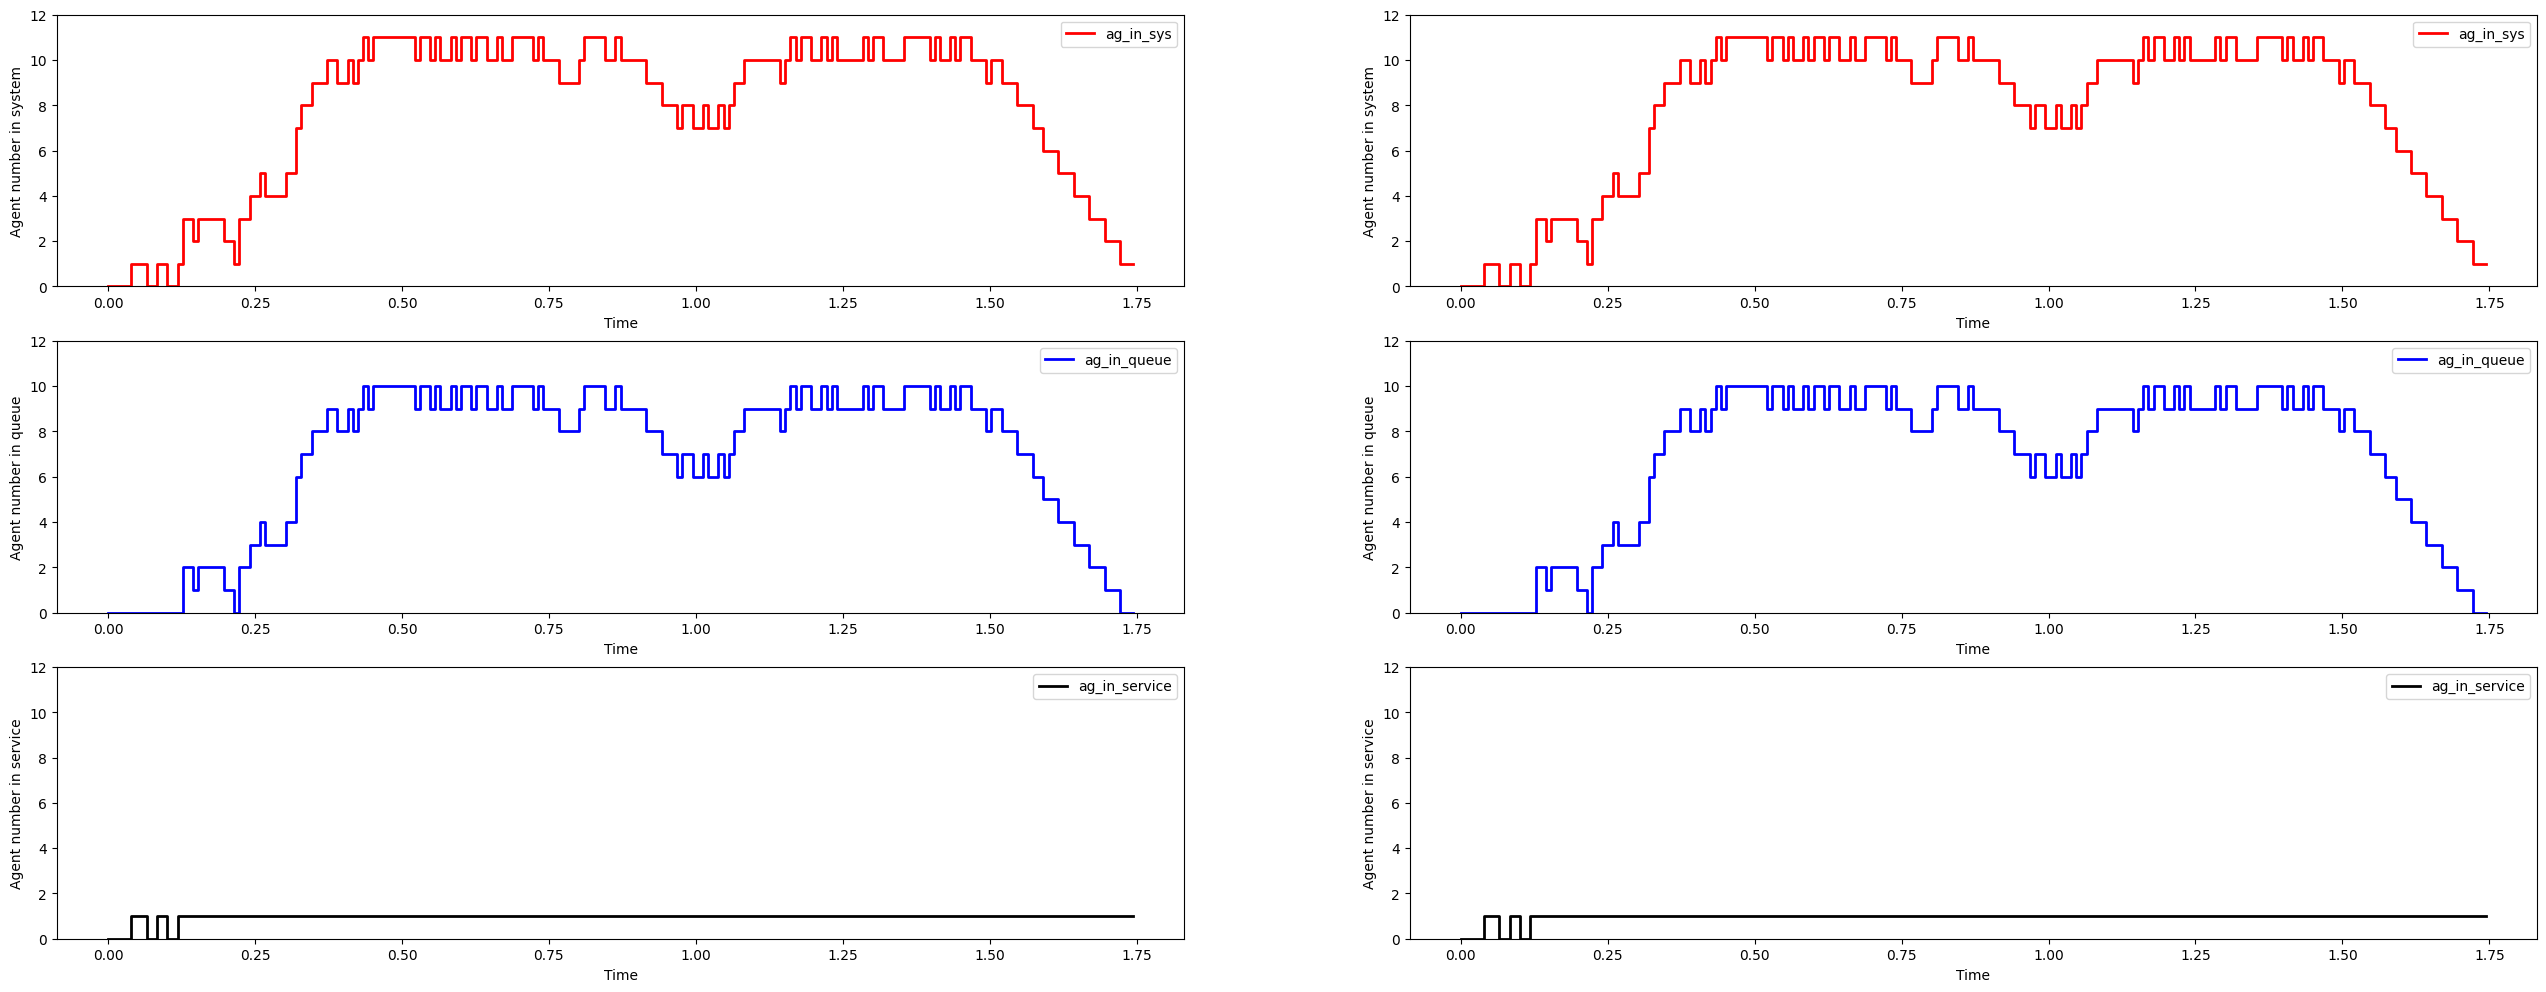

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(32, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    mm1_fifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,0], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_fifo_bench['ag_in_sys']+1)])
    
    mm1_lifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,1], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_lifo_bench['ag_in_sys']+1)])

0.05694224555200032
0.05694224555200032


,run value_fifo,run value_lifo
mean_sojourn_time,1.334576,1.334576
mean_waiting_time,1.084576,1.084576
mean_service_time,0.25,0.25
waiting_proportion,0.945361,0.945361
blocked_proportion,0.03,0.03
servers_max_usage,0.947474,0.947474
longest_wait_time,2.498004,37.401151
wait_time_std,0.712511,3.199509


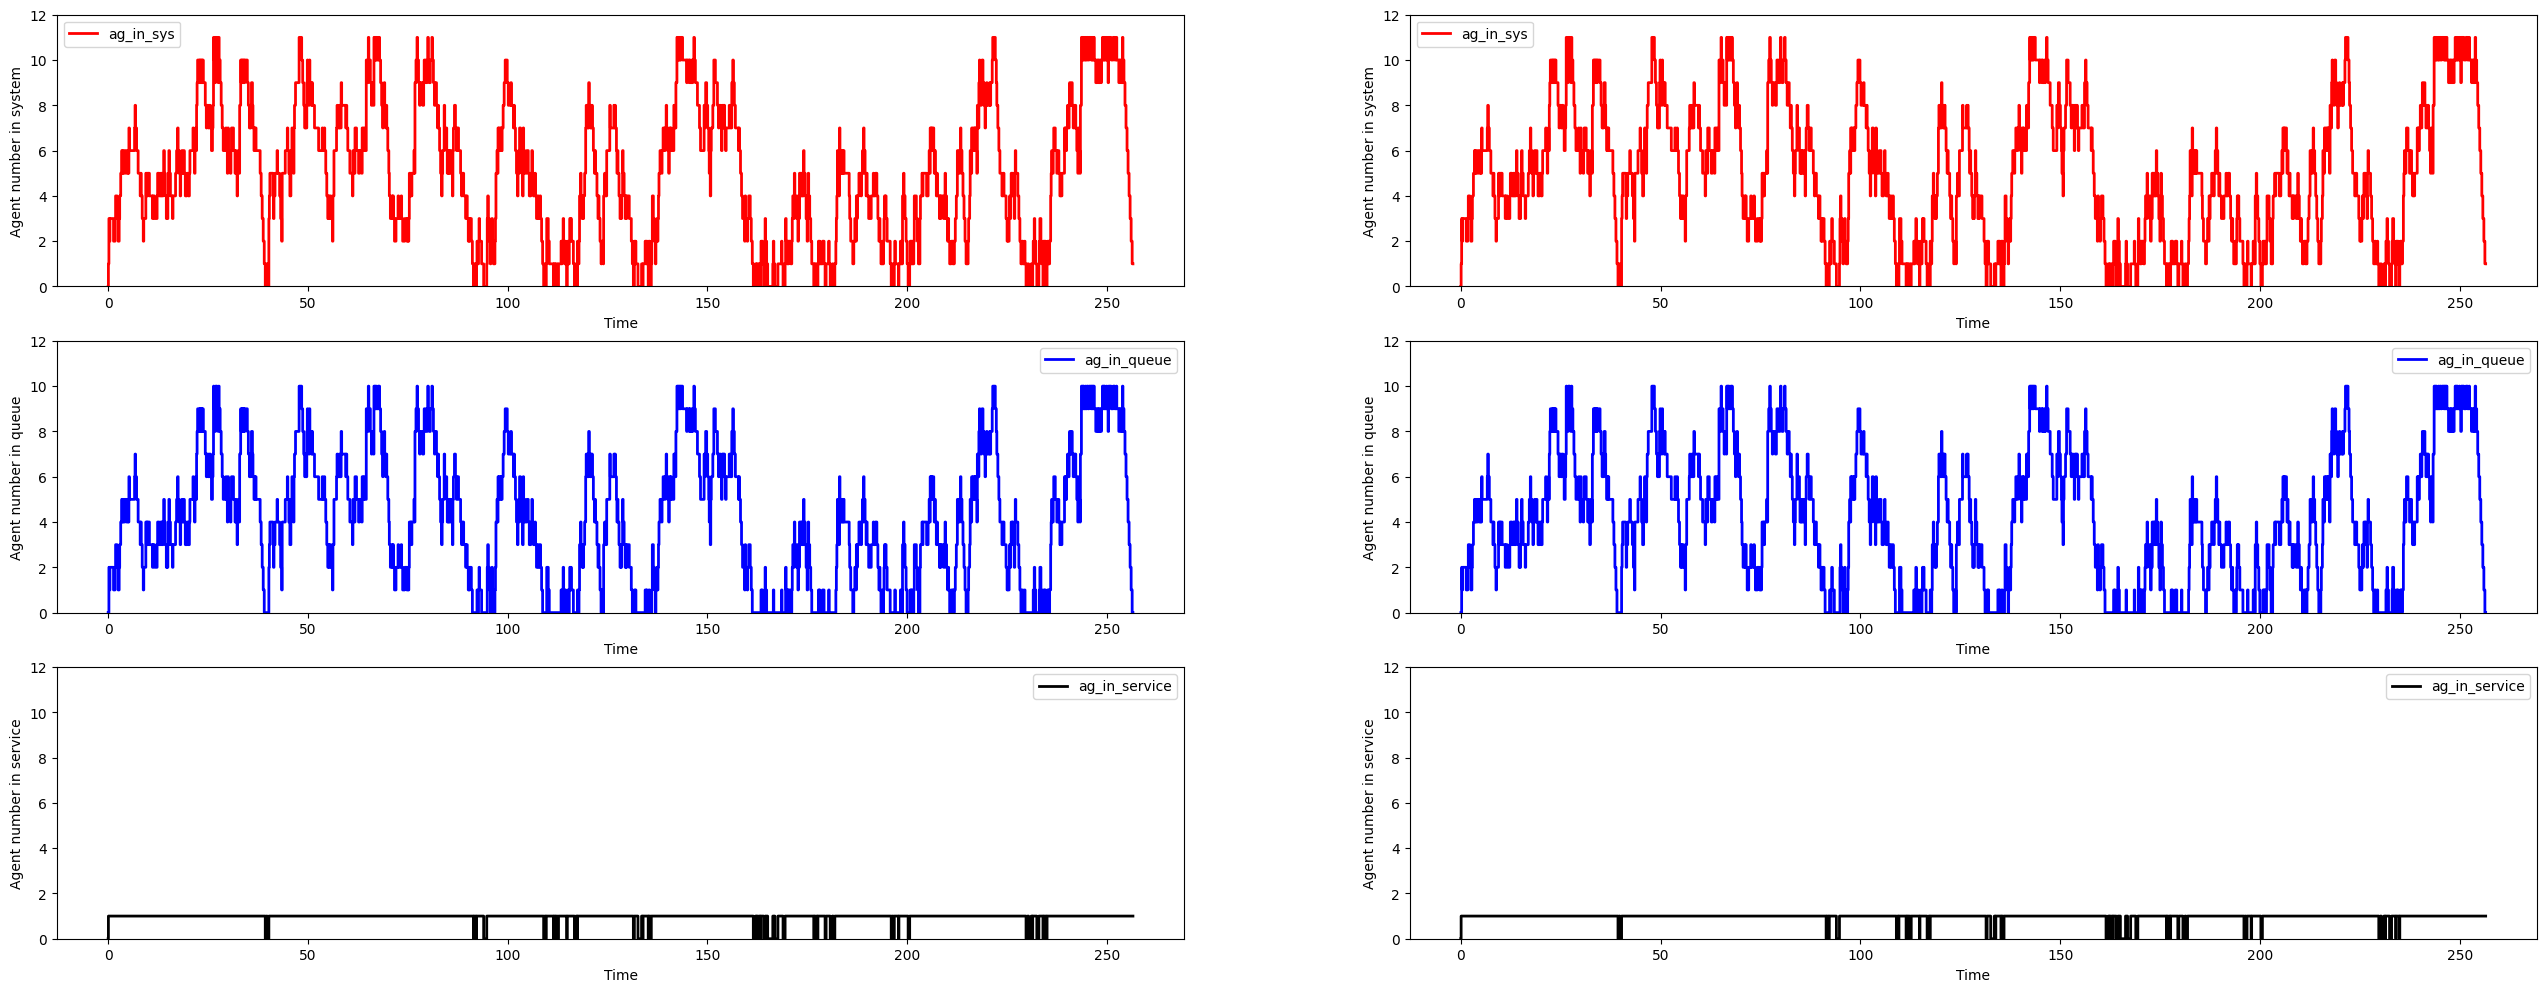

In [64]:
#signature : simulate(srv_nb, queue_size, test_size, seed, arrival_speed: float, srv_speed: float):

# same arrival speed and srv_speed
simulate(1, 10, 1000, 42, 1./4., 1./4)


0.022776898220800132
0.022776898220800132


,run value_fifo,run value_lifo
mean_sojourn_time,2.588489,2.588489
mean_waiting_time,2.338489,2.338489
mean_service_time,0.25,0.25
waiting_proportion,0.997602,0.997602
blocked_proportion,0.583,0.583
servers_max_usage,1.0,1.0
longest_wait_time,2.499972,103.96828
wait_time_std,1.167512,8.771167


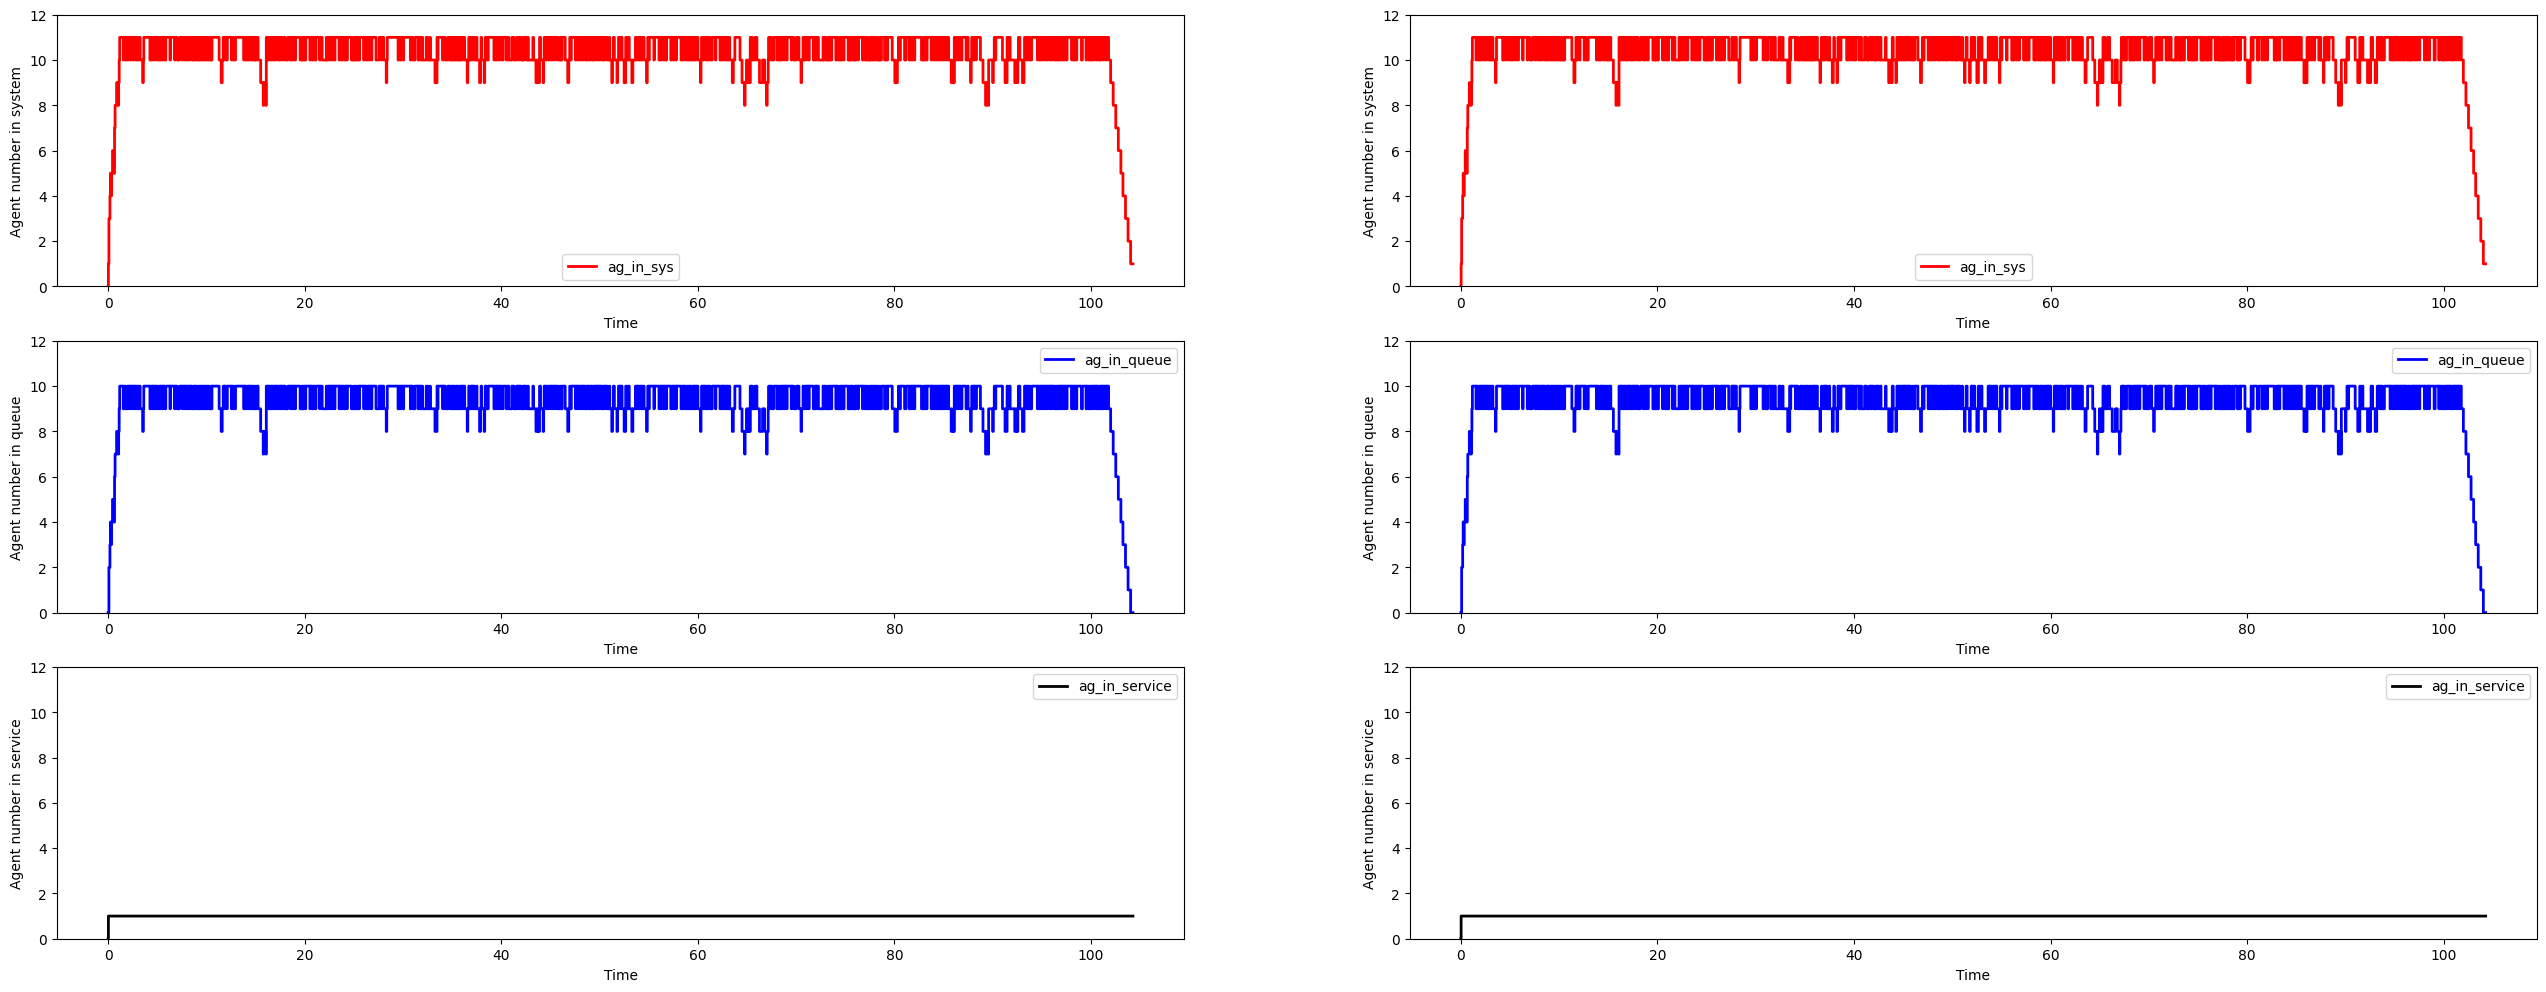

In [65]:
# fast arrival speed, slow srv_speed
simulate(1, 10, 1000, 42, 1./10., 1./4)

0.05694224555200032
0.05694224555200032


,run value_fifo,run value_lifo
mean_sojourn_time,0.1317,0.1317
mean_waiting_time,0.0317,0.0317
mean_service_time,0.1,0.1
waiting_proportion,0.391,0.391
blocked_proportion,0.0,0.0
servers_max_usage,0.385193,0.385193
longest_wait_time,0.372956,1.193696
wait_time_std,0.055027,0.078928


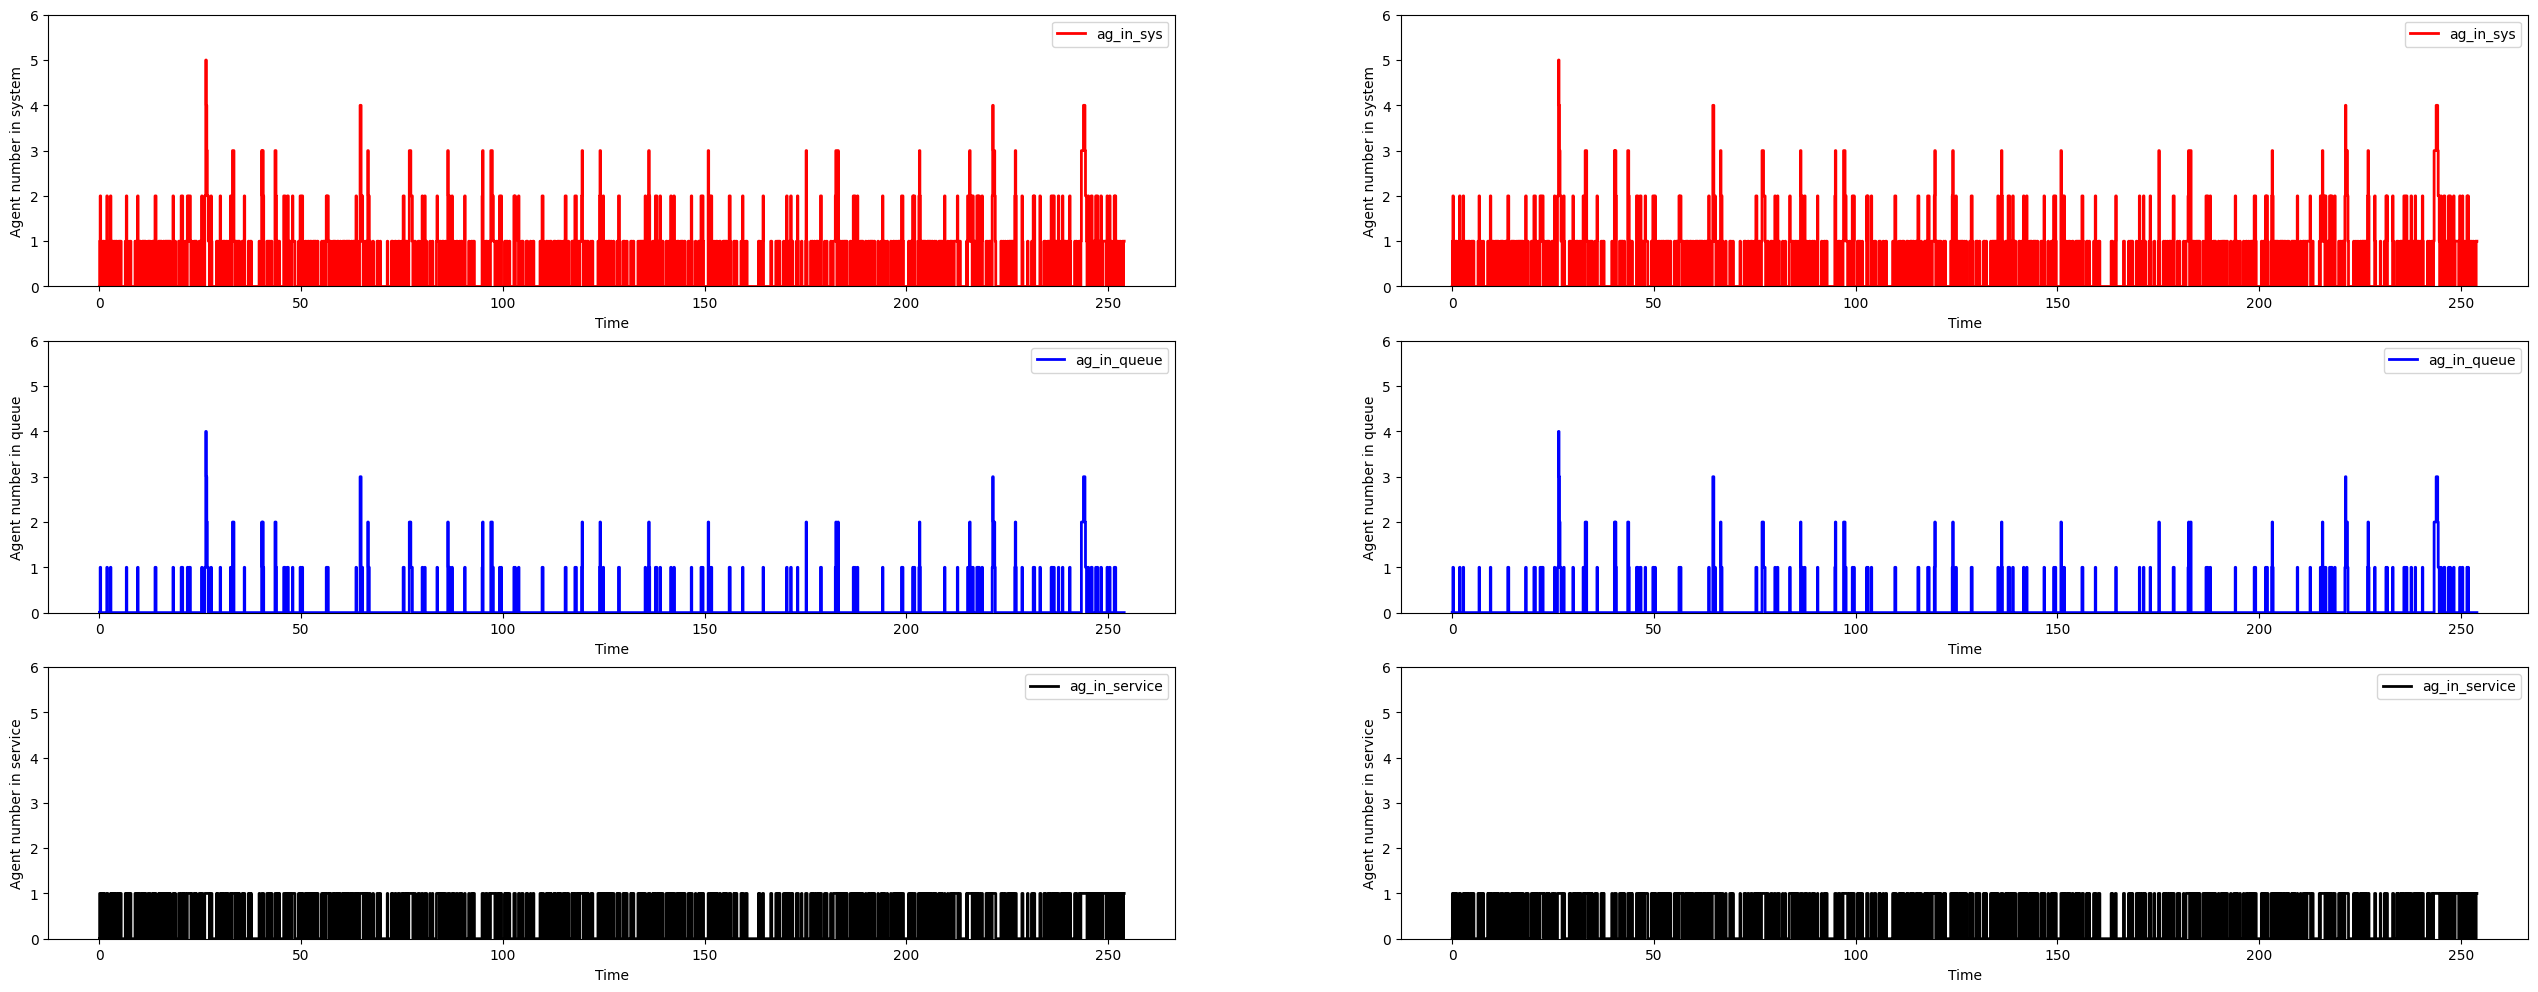

In [66]:
# slow arrival speed and fast srv_speed
simulate(1, 10, 1000, 42, 1./4., 1./10)


In [ ]:
# Very large queue size to simulate M/M/1 and M/M/1/LIFO
simulate(1, 10, 10000, 42, 1./10., 1./4)

# We can see the wait time is even worse, if there is no limit than in theory the wait time could be infinte.

To Recap, I have carefully simulated the M/M/1/k (FIFO) and M/M/1/k/LIFO queues using the same sample set and under different conditions, which is critical for a valid comparison between these two systems.

It's interesting to note that the average service time (mean_service_time), average sojourn time (mean_sojourn_time), waiting proportion (waiting_proportion), and blocked client proportion (blocked_proportion) are identical for both FIFO and LIFO policies. TThis is due to fixing the arrival and service times for both policies, meaning the only change is the order in which customers are served.

However, the longest wait times (longest_wait_time) and the standard deviation of the wait time (wait_time_std) are much higher for LIFO than for FIFO. This is a direct consequence of the LIFO policy: the last customer to arrive is served first, so customers who arrive first can end up waiting for a very long time if new customers continue to arrive. This could be a major disadvantage of the LIFO policy in certain situations, for example in a context where it's important to minimize customer wait time.

These systems reach a certain balance regardless of the queue size, at least for the parameters I've tested.

As for the question of whether the conclusions change for M/M/1 and M/M/1/LIFO systems without a queue capacity limit, one might expect the observed differences between FIFO and LIFO to be even more pronounced. In particular, without a queue capacity limit, the wait times for customers who arrive first in a LIFO system could become extremely long. However, this would also depend on the specific arrival and service rates of our system.

# Question 2

On suppose avoir à diposition $5$ serveurs $s_1$, $\ldots$, $s_5$ et $3$ files d'arrivées *FIFO* $f_1$, $f_2$, $f_3$ de tailles respectives $z_1$, $z_2$, $z_3$. Les temps de services de nos serveurs sont respectivements donnés par des lois exponentielles paramètres $\mu_1$, $\ldots$, $\mu_5$, ordonnés par ordre croissant.  

Une population d'agents s'adresse à notre service, déployé identitiquement sur chaque serveur. On constate que cette population est décomposée en $5$ sous-populations $A_1$, $\ldots$, $A_5$ dont les processus d'arrivées sont respectivement d'intensités $\lambda_1$, $\ldots$, $\lambda_5$, ordonnés par ordre croissants. Les tailles respectives de chacune des populations sont $a_1$, $\ldots$, $a_5$ ; elles vérifient les relations $a_i > 2\max\{z_1, z_2, z_3\}$ pour tout $1 \leq i \leq 3$.   

1. Simuler un système d'attente qui permet de répondre aux besoins de services.
2. Comparer un minimum de trois architectures possibles, au regard des ressources à disposition, pour répondre aux besoins de services. Vous êtes attendus sur des simulations appuyants vos propos.
3. Quelles modifications apporteriez-vous sur votre proposition si l'on introduit une fonction de dissatisfaction des agents donnée par $ b_1 + 2 b_2 + \cdots 5 b_5$, où $b_i$ correspond au nombre d'agents de la populations $A_i$ qui n'ont pas pu avoir accès au système ?

Vous êtes autorisé d'effectuer des hypothèses simplificatrices dans votre travail. Attention à ce qu'elles ne soient pas *trop* simplificatrices.

 In order to adapt the previous code we will need to make some modifications, for example, the number of queue is set 1 and we need 3 queues. We will also need several populations with different distribution. Fun times
 
 
 Ok oK so if we want a basic archi that will work, we can have something like dedicated servers and subpopulations for each queue. Since s1 is fastest and A5 is the most intense we want to match them for best performance. We will end up with something like F1 : A5 : s1  F2 : (A4, A3) : (s2, s3) F3 : (A2, A1) : (s4, s5)
 
 This means that first queue will have one server, second queue will serve 2 sub-populations and 2 servers etc...
 
 This is straigth forward, we will need to add subpopulations though and we can reuse our simulate function.
 

In [ ]:
def combinePopulations(population_size_1, lambda_1, population_size_2, lambda_2):
    # Generate the new population size and lambda
    new_population_size = population_size_1 + population_size_2
    new_lambda = lambda_1 + lambda_2

    # Define the arrival distribution for the combined population
    arval_dist = lambda size: rng.exponential(scale=1 / new_lambda, size=size)

    # Return the new population information
    return new_population_size, new_lambda

def combineServers(mu1, mu2):
    # Generate the new mu for the combined server
    new_mu = (mu1 + mu2) / 2
    
    return new_mu

In [ ]:
# Sub-population sizes and arrival rates
population_sizes = [65, 85, 105, 125, 150]  # a1, a2, a3, a4, a5
lambdas = [0.1, 0.2, 0.3, 0.4, 0.5]  # lambda1, lambda2, lambda3, lambda4, lambda5
mus = [0.5, 0.6, 0.7, 0.8, 0.9]  # Paramètres de temps de service pour chaque serveur
queue_sizes = [10, 20, 30]  # Tailles de files d'attente
server_counts = [1, 2, 2]
test_size = 1000

# Combine populations for queue F2 and F3
population_size_f2, lambda_f2 = combinePopulations(population_sizes[3], lambdas[3], population_sizes[2], lambdas[2])  # A4 + A3
population_size_f3, lambda_f3 = combinePopulations(population_sizes[1], lambdas[1], population_sizes[0], lambdas[0])  # A2 + A1

# Update population_sizes and lambdas for three queues
population_sizes_f = [population_sizes[4], population_size_f2, population_size_f3]  # F1: A5, F2: A4+A3, F3: A2+A1
lambdas_f = [lambdas[4], lambda_f2, lambda_f3]  # Update lambdas for combined populations

# Now, rerun the previous code with updated population sizes and lambdas
queues = []
for i in range(3):  # three queues
    arval_dist = lambda size: rng.exponential(1/lambdas_f[i], size=size)
    srv_dist = lambda size: rng.exponential(1/mus[i], size=size)
    fifo_policy = lambda x: 0
    mm1_fifo = QS(arval_dist, srv_dist, server_counts[i], queue_size=queue_sizes[i], test_size=population_sizes_f[i], policy=fifo_policy)
    queues.append(mm1_fifo)

for queue in queues:
    queue.pretreat()
    queue.run()
    queue.posttreat()
    queue_bench, queue_stats = queue.timeline()
    display(queue_stats)
    fig, axes = plt.subplots(3, 1, figsize=(32, 12))
    counts = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
    labels = ['system', 'queue', 'service']
    colors = ['red', 'blue', 'black']
    for i in range(3):
        queue_bench.plot(y=counts[i], 
                         use_index=True, ax=axes[i], linewidth=2, drawstyle='steps-mid', color=f'{colors[i]}',
                         ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(queue_bench['ag_in_sys']+1)])


Now the shared archi is a lot more complicated, every queue will have access to all the servers. Which queue gets poped can be based on various criteria such as wether a queue is full or by using the round robin strategy (naive). 

In [ ]:
Finally we have the mixed strategy, having a dedicated server and queue for a sub-population, much like a VIP queue.
And then a shared architecture for the rest of the plebs.



In [ ]:
class MultiQS:
    def __init__(self, subpopulations, queue_sizes, servers_nb, srv_dist, policy=lambda x: 0, test_size=100):
        self.subpopulations = subpopulations
        self.queue_sizes = queue_sizes
        self.servers_nb = servers_nb
        self.srv_dist = srv_dist
        self.policy = policy
        self.test_size = test_size
        self.qs_list = []

        # Assign subpopulations to queues
        queue_assignments = self.assign_subpopulations(subpopulations, queue_sizes)

        # Create a separate QS object for each queue assignment
        for queue_assign in queue_assignments:
            arval_dist = [subpop['arval_dist'] for subpop in queue_assign['subpopulations']]
            qs = QS(arval_dist, srv_dist, servers_nb, queue_assign['queue_size'], policy, test_size)
            self.qs_list.append(qs)

    def assign_subpopulations(self, subpopulations, queue_sizes):
        num_subpops = len(subpopulations)
        num_queues = len(queue_sizes)
        queue_assignments = []

        for i in range(num_queues):
            queue_assign = {
                'queue_size': queue_sizes[i],
                'subpopulations': []
            }
            for j in range(i, num_subpops, num_queues):
                queue_assign['subpopulations'].append(subpopulations[j])
            queue_assignments.append(queue_assign)

        return queue_assignments

    def pretreat(self):
        for qs in self.qs_list:
            qs.pretreat()

    def run(self):
        for qs in self.qs_list:
            qs.run()

    def posttreat(self):
        for qs in self.qs_list:
            qs.posttreat()



In [ ]:
# Define the subpopulations and their characteristics
subpopulations = [
    {
        'arval_dist': lambda size: rng.exponential(0.1, size=size),  # Arrival distribution for subpopulation A1
        'size': 50  # Size of subpopulation A1
    },
    {
        'arval_dist': lambda size: rng.exponential(0.2, size=size),  # Arrival distribution for subpopulation A2
        'size': 40  # Size of subpopulation A2
    },
    # Add the other subpopulations (A3, A4, A5) with their respective characteristics
]

queue_sizes = [20, 30, 40]  # Sizes of the queues

servers_nb = 5  # Number of servers

srv_dist = lambda size: [1.0 / mu for mu in mus]  # Server distribution for all servers

policy = lambda x: 0  # Queue policy

test_size = 1000  # Test size for simulation

# Create an instance of MultiQS
multi_qs = MultiQS(subpopulations, queue_sizes, servers_nb, srv_dist, policy, test_size)

# Perform the pre-processing step
multi_qs.pretreat()

# Run the simulation
multi_qs.run()

# Perform the post-processing step
multi_qs.posttreat()



In [ ]:


class MultiQS():
    
    def __init__(self, arval_dists, srv_dists, servers_nb, queues_nb, queue_sizes=None, populations_sizes=None):
        # Initializing metadata
        self.arval_dists = arval_dists
        self.srv_dists = srv_dists
        self.servers_nb = servers_nb
        self.queues_nb = queues_nb
        self.queue_sizes = queue_sizes if queue_sizes else [None] * queues_nb
        self.populations_sizes = populations_sizes if populations_sizes else [None] * queues_nb
        self.wlines = []
        self.inservice = InService(nb=servers_nb)
        self.tops = None

    def pretreat(self, test_size):
        self.tops = pd.DataFrame(np.empty((test_size, 3), dtype=object), columns=['t_arval_queue', 't_arval_srv', 't_depart_sys'])
        for queue_idx in range(self.queues_nb):
            arval_dist = self.arval_dists[queue_idx]
            queue_size = self.queue_sizes[queue_idx]
            population_size = self.populations_sizes[queue_idx]
            t_interarvals = arval_dist(size=population_size)
            self.tops.loc[0, 't_arval_queue'] = t_interarvals[0]
            for agent in range(1, population_size):
                self.tops.loc[agent, 't_arval_queue'] = self.tops.loc[agent - 1, 't_arval_queue'] + t_interarvals[agent]
            self.wlines.append(Wline(size=queue_size))
        
    def run(self):

        # Easing naming
        wline = self.wline
        inservice = self.inservice
        tops = self.tops
        processing_times = inservice.dist(size=(self.test_z))

        # Initializing arrival queue
        # Get the arrival times from the tops DataFrame
        arrival_times = tops['t_arval_queue'].values

        # wline.queue = list(tops.loc[:self.queue_z].index)
        wline.queue = list(tops.loc[0:0].index)  # Add the first agent to the waiting line
        # Initializing upcomgin theoretical arrival
        buffer_ix = 1
        current_time = arrival_times[0]

        print(current_time)

        while buffer_ix < self.test_z:
            _next = wline.pop()
            if _next is not None:  # Waiting line is not empty
                print(f"_next : {_next}")
                # print(f"arrival of next : {tops.loc[_next, 't_arval_queue']}")

                # Update server arrival time as if no waiting was needed
                tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']

                # Find next available server
                srv_ix, dept_ag = inservice.leaving(tops)

                # Fill available server with corresponding next agent in waiting line
                inservice.server[srv_ix] = _next

                if dept_ag is not None:
                    if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys']:
                        # Update server arrival time in case arrival is before system departure
                        tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']

                # Update system departure time
                tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + processing_times[_next]
                current_time = tops.loc[inservice.server, 't_depart_sys'].min() #closest departure time on the whole system because dept_ag doesn't work


            else:
                current_time = arrival_times[buffer_ix]  # Get next arrival time, in case we don't get any clients by the time we are done processing current client


            while buffer_ix < self.test_z and arrival_times[buffer_ix] <= current_time:
                in_system = ((tops['t_depart_sys'] > current_time) | (tops.index.isin(wline.queue)) | (tops.index == _next)).sum()
                if self.queue_z is not None and in_system >= self.queue_z + self.inservice.nb:
                    tops.loc[buffer_ix, 't_depart_sys'] = -1
                else:
                    wline.add(buffer_ix)
                buffer_ix += 1

            #buffer_ix += 1
            if (_next != None):
                current_time = tops.loc[_next, 't_depart_sys']
            print("Current Time: ", current_time)
            print("Current Queue:", wline.queue)

            # ok so in lifo I noticed that the first length - 1 elements don't ever get processed
            # because our server is too slow so once the buffer_ix gets exceeded, it cuts everything off.
            # I still want to process the queue
        while not wline.is_empty():

            _next = wline.pop()
            print(f"_next : {_next}")
            # print(f"arrival of next : {tops.loc[_next, 't_arval_queue']}")

            # Update server arrival time as if no waiting was needed
            tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']

            # Find next available server
            srv_ix, dept_ag = inservice.leaving(tops)

            # Fill available server with corresponding next agent in waiting line
            inservice.server[srv_ix] = _next

            if dept_ag is not None:
                if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys']:
                    # Update server arrival time in case arrival is before system departure
                    tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']

            # Update system departure time
            tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + processing_times[_next]
            current_time = tops.loc[inservice.server, 't_depart_sys'].min() #closest departure time on the whole system because dept_ag doesn't work
            print("Current Time: ", current_time)
            print("Current Queue:", wline.queue)

                
    def posttreat(self):
        
        #Easing naming
        tops = self.tops
        
        tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
        tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
        tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
        tops['blocked'] = tops.loc[:,'t_depart_sys'] == -1
        tops['waited'] = tops['t_waiting'] > 0 
        
    
    def timeline(self, t_delation=2):
        
        #Easing naming
        tops = self.tops
        test_z = self.test_z

        # Process determination
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., tops['t_depart_sys'].max(), t_delation*test_z)
        process = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)
        
        for t in process.index:
            process.loc[t, 'ag_in_sys'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_depart_sys'])).sum()
            process.loc[t, 'ag_in_queue'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_arval_srv'])).sum()
            process.loc[t, 'ag_in_service'] = ((t > tops['t_arval_srv']) & (t <= tops['t_depart_sys'])).sum()
        
        # Statistics extractions
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 
                     'waiting_proportion', 'blocked_proportion', 'servers_max_usage']
        stats = pd.DataFrame(np.empty((len(statnames), 1),dtype=object), index=statnames, columns=['run value'])
 
        stats.loc['mean_sojourn_time'] = tops['t_sojourn'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_waiting_time'] = tops['t_waiting'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_service_time'] = tops['t_service'].sum() / (~tops['blocked']).sum()

        stats.loc['waiting_proportion'] = tops['waited'].sum() / (~tops['blocked']).sum()
        stats.loc['blocked_proportion'] = tops['blocked'].sum() / test_z

        # An approximation of server usage, for better approximation raise t_delation.
        stats.loc['servers_max_usage'] = (process['ag_in_service'] == self.inservice.nb).sum() / (t_delation*test_z - 1)
        
        # Calculate longest wait time
        longest_wait_time = tops['t_waiting'].max()
        
        #Caculate the standard deviation
        wait_time_std = tops['t_waiting'].std()
        
        
        stats.loc['longest_wait_time'] = longest_wait_time
        stats.loc['wait_time_std'] = wait_time_std
        return process, stats """

In [ ]:
lambdas = [0.1, 0.2, 0.3, 0.4, 0.5]  # Intensités d'arrivée pour chaque sous-population
mus = [0.5, 0.6, 0.7, 0.8, 0.9]  # Paramètres de temps de service pour chaque serveur
queue_sizes = [10, 20, 30]  # Tailles de files d'attente
population_sizes = [65, 85, 105, 125, 150]  # Tailles de sous-populations
server_count = 5
test_size = 1000
populations = []

# For each sub-population...
for i in range(len(lambdas)):
    # Generate the arrival times and service times for this population
    arrival_times = np.random.exponential(1./lambdas[i], size=population_sizes[i])
    service_times = np.random.exponential(1./mus[i], size=population_sizes[i])

    # Add this population to the list
    populations.append((arrival_times, service_times))

# Now add all the populations together
all_arrival_times = np.concatenate([p[0] for p in populations])
all_service_times = np.concatenate([p[1] for p in populations])

print("len of pops", len(all_arrival_times), "\n", all_arrival_times)

# Define the arrival and service distributions
arval_dists = [lambda size: np.random.exponential(1./l, size=size) for l in lambdas]
srv_dists = [lambda size: np.random.exponential(1./mu, size=size) for mu in mus]

# Initialize the queue systems
queue_systems = [QS(arval_dist=arval_dists[i], 
                    srv_dist=srv_dists[i], 
                    servers_nb=5, 
                    queue_size=queue_sizes[i % 3],  # Distribute the queues among the systems
                    policy=lambda x:0, 
                    test_size=population_sizes[i])
                 for i in range(5)]

# Run the queue systems
for qs in queue_systems:
    qs.pretreat()
    qs.run()
    qs.posttreat()

# At this point, each instance of QS contains the results of the simulation
# for one of the sub-populations.

    